In [1]:
# imports and laodings
import pandas as pd
import pickle
import matplotlib.pyplot as plt
import numpy as np


# settings
basal_conditions = ['control__wt_glc__1'] #'crp__delar1ar2_glyc__2'

A_df = pd.read_csv('../data/precise_1.0/A.csv', index_col = 0)
iM_table = pd.read_csv('../data/precise_1.0/iM_table.csv', index_col = 0)
A_df = A_df.rename(index = {index : row['name'] for index, row in iM_table.iterrows()})

M_df = pd.read_csv('../data/precise_1.0/M.csv', index_col = 0)
M_df = M_df.rename(columns = {str(index) : row['name'] for index, row in iM_table.iterrows()})

log_tpm_df = pd.read_csv('../data/precise_1.0/log_tpm.csv', index_col = 0)
A_df = A_df[log_tpm_df.columns]

# defining constants
RNAP = 1*10**(-6)
kEscape = 1
TF = 0
u = 1/3600
kDeg = 0.00231049
promoterConc = 1*10**(-9)
promoterConcVal = 10**(-9)
KdRNAPCrp = 10**(-8)

#KdRNAP = 10**(-5)
#kEscape = 10**(1)
#KeqOpening = 10**(-2.934477355721568)
pickle_in = open('../data/pickle_dicts/center_cond_to_gene_to_grid_values.pkl', 'rb')
center_cond_to_gene_to_grid_values = pickle.load(pickle_in)
pickle_in.close()
grid_vals = center_cond_to_gene_to_grid_values[basal_conditions[0]]['b1101']
grid_use = -1
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])

def mRNA_to_cActivator(mRNA, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, kEscape = kEscape, KeqOpening = KeqOpening): # this appears to be properly working!
    cActivator = -((KdRNAPCrp * (kDeg * mRNA * (KdRNAP + RNAP + \
                    KeqOpening * RNAP) + mRNA * (KdRNAP + RNAP) * u + \
                    KeqOpening * (-1*kEscape * promoterConcVal * RNAP + \
                    mRNA * RNAP * u)))/(KdRNAP * (kDeg * mRNA * (KdRNAPCrp + RNAP + \
                    KeqOpening * RNAP) + mRNA * (KdRNAPCrp + RNAP) * u + \
                    KeqOpening * (-1*kEscape * promoterConcVal * RNAP + mRNA * RNAP * u))))
    
    return(cActivator)

def mRNA_to_cInhibitor(mRNA, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, kEscape = kEscape, KeqOpening = KeqOpening): # I think the mathematica code might have an error, I'm sticking with this
    cInhibitor = (1/(KdRNAP * mRNA * (kDeg + u))) * (-1*kDeg * KdRNAP * mRNA - kDeg * mRNA * RNAP - \
                  kDeg * KeqOpening * mRNA * RNAP + KeqOpening * kEscape * promoterConc * RNAP - \
                  KdRNAP * mRNA * u - mRNA * RNAP * u - KeqOpening * mRNA * RNAP * u)
    return(cInhibitor)

def cActivator_to_mRNA(cActivator, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, kEscape = kEscape, KeqOpening = KeqOpening):
    mRNA = ((cActivator * KdRNAP + KdRNAPCrp) * KeqOpening * kEscape * promoterConcVal * RNAP)/(((1 + \
         cActivator) * KdRNAP * KdRNAPCrp + cActivator * KdRNAP * (1 + KeqOpening) * RNAP + \
         KdRNAPCrp * (1 + KeqOpening) * RNAP) * (kDeg + u))
    return(mRNA)
    
def cInhibitor_to_mRNA(cInhibitor, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, kEscape = kEscape, KeqOpening = KeqOpening):
    mRNA = (KeqOpening * kEscape * promoterConcVal * RNAP)/(((1 + \
       cInhibitor) * KdRNAP + (1 + KeqOpening) * RNAP) * (kDeg + u))
    return(mRNA)

def cActivator_cInhibitor_to_mRNA(cActivator, cInhibitor, KdRNAP = KdRNAP, KdRNAPCrp = KdRNAPCrp, kEscape = kEscape, KeqOpening = KeqOpening):
    mRNA = ((cActivator * KdRNAP + \
            KdRNAPCrp) * KeqOpening * kEscape * promoterConc * RNAP)/((KdRNAP * \
            KdRNAPCrp + cActivator * KdRNAP * KdRNAPCrp + \
            cInhibitor * KdRNAP * KdRNAPCrp + cActivator * KdRNAP * RNAP + \
            KdRNAPCrp * RNAP + cActivator * KdRNAP * KeqOpening * RNAP + \
            KdRNAPCrp * KeqOpening * RNAP) * (kDeg + u))
    return(mRNA)

def log_tpm_to_mRNA_conc(val):
    if False: # old way of doing this
        mRNA = 2**val * sample_to_tot_reads[key] * ((gene_to_len[gene] - sample_to_avg_frag_lenght[key]) / 1000) / tpm_div # convert from log tpm back to gene count
    else:
        mRNA = (2**val)*(10**-6)*1800/cell_volume/(6.022*(10**23))
    return(mRNA)

# calculate mRNA predicted and actual values

In [2]:
# TODOS - one, swtich cInhibitor to the other iModulon for sovling, 2 need to conver tthis version of mRNA to true (need to unlog and uncetner)
# TODO - need to parameter sweep with KdRNAPCrp and KdRNAP to find sweet spot where our values live basically

# I can't convert log tpm to mRNA without the gene counts from these
gene = 'b1101'

# constants
cell_volume = 10**(-15) # in liters
controls = basal_conditions

if True:
    # crp is the activator
    decentered = log_tpm_df[['control__wt_glc__1', 'control__wt_glc__2']].mean(axis = 1)[gene]
    act_vals = []
    mRNAs = []
    index = []
    actual_counts = []
    # predict mRNA values
    for key, val in (A_df.loc['Crp-2']*M_df['Crp-2'].loc[gene]).items():
        index.append(key)
        val += decentered
        mRNA = log_tpm_to_mRNA_conc(val) # convert from log tpm to mRNA concentration
        mRNAs.append(mRNA)
        actual_counts.append(log_tpm_to_mRNA_conc(log_tpm_df.loc[gene][key]))#(counts_df.loc[gene][key] / 1800 / cell_volume) / 6.02214e23)

In [3]:
    act_values_df = pd.DataFrame(index = index)
    act_values_df['mRNA'] = mRNAs
    act_values_df['actual_mRNA'] = actual_counts
    # scale one by the other
    mean1 = np.mean(act_values_df['mRNA'])
    std1 = np.std(act_values_df['mRNA'])
    mean2 = np.mean(act_values_df['actual_mRNA'])
    std2 = np.std(act_values_df['actual_mRNA'])
    rescaled_array1 = (act_values_df['mRNA'] - mean1) * (std2 / std1) + mean2
    act_values_df['scaled_mRNA'] = rescaled_array1
    # calculate activator values
    for index, row in act_values_df.iterrows():
        mRNA = row['mRNA']
        cActivator = mRNA_to_cActivator(mRNA)
        act_vals.append(cActivator)
    act_values_df['cActivator'] = act_vals

In [4]:
    # mlc is the repressor
    iM = 'DhaR/Mlc'
    inh_vals = []
    mRNAs = []
    index = []
    actual_counts = []
    # predict mRNA values
    for key, val in (A_df.loc[iM]*M_df[iM].loc[gene]).items():
        index.append(key)
        val += decentered
        mRNA = log_tpm_to_mRNA_conc(val)
        mRNAs.append(mRNA)
        actual_counts.append(log_tpm_to_mRNA_conc(log_tpm_df.loc[gene][key]))#(counts_df.loc[gene][key] / 1800 / cell_volume) / 6.02214e23)
    inh_values_df = pd.DataFrame(index = index)
    inh_values_df['mRNA'] = mRNAs
    inh_values_df['actual_mRNA'] = actual_counts
    
    # scale one by the other
    mean1 = np.mean(inh_values_df['mRNA'])
    std1 = np.std(inh_values_df['mRNA'])
    mean2 = np.mean(inh_values_df['actual_mRNA'])
    std2 = np.std(inh_values_df['actual_mRNA'])
    rescaled_array1 = (inh_values_df['mRNA'] - mean1) * (std2 / std1) + mean2
    inh_values_df['scaled_mRNA'] = rescaled_array1
    # calculate inhibitor values
    for index, row in inh_values_df.iterrows():
        mRNA = row['mRNA']
        cInhibitor = mRNA_to_cInhibitor(mRNA)
        inh_vals.append(cInhibitor)
    inh_values_df['cInhibitor'] = inh_vals

In [5]:
act_values_df

,mRNA,actual_mRNA,scaled_mRNA,cActivator
control__wt_glc__1,7.077094e-09,6.692977e-09,3.888316e-09,0.000064
control__wt_glc__2,6.858091e-09,7.251684e-09,3.615636e-09,0.000027
fur__wt_dpd__1,3.572738e-09,1.501439e-09,-4.749616e-10,-0.000491
fur__wt_dpd__2,3.237107e-09,1.506883e-09,-8.928562e-10,-0.000541
fur__wt_fe__1,7.169373e-09,5.377572e-09,4.003214e-09,0.000079
...,...,...,...,...
efeU__menFentCubiC_ale36__2,6.122016e-09,6.412137e-09,2.699148e-09,-0.000093
efeU__menFentCubiC_ale37__1,6.198059e-09,5.322417e-09,2.793829e-09,-0.000081
efeU__menFentCubiC_ale37__2,6.262865e-09,5.141451e-09,2.874519e-09,-0.000070
efeU__menFentCubiC_ale38__1,7.248363e-09,5.550015e-09,4.101564e-09,0.000092


# parameter optimization

Optimization successful.
KdRNAPCrp = 1e-08


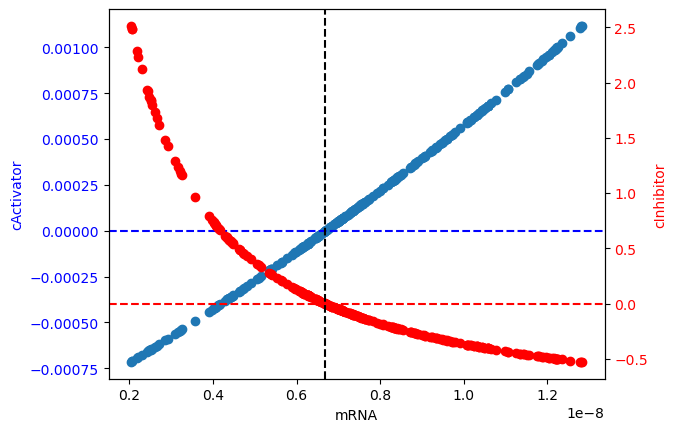

In [6]:
# chatGPT suggestion - use scipy to solve, only modify KdRNAPCrp
from scipy.optimize import basinhopping
import numpy as np

# modified using Griff's options
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])

activator_mRNA_values = list(act_values_df.sort_values(by = 'mRNA').mRNA.values)
inhibitor_mRNA_values = list(inh_values_df.sort_values(by = 'mRNA').mRNA.values)

def objective(x):
    KdRNAPCrp_temp = x[0]
    KdRNAP_temp = KdRNAP
    kEscape_temp = kEscape
    KeqOpening_temp = KeqOpening
    
    if KdRNAPCrp_temp > KdRNAP:
        # this doesn't make biological sense
        return(1e10) # return a high penalty
    
    cActivator_values = []
    for mRNA in activator_mRNA_values:
        cActivator = mRNA_to_cActivator(mRNA, KdRNAP = KdRNAP_temp, KdRNAPCrp = KdRNAPCrp_temp, kEscape = kEscape_temp, KeqOpening = KeqOpening_temp)
        cActivator_values.append(cActivator)
        
    cInhibitor_values = []
    for mRNA in inhibitor_mRNA_values:
        cInhibitor = mRNA_to_cInhibitor(mRNA, KdRNAP = KdRNAP_temp, KdRNAPCrp = KdRNAPCrp_temp, kEscape = kEscape_temp, KeqOpening = KeqOpening_temp)
        cInhibitor_values.append(cInhibitor)
    
    penalty = 0
    diff = 0
    diff += abs(100 - abs(max(cActivator_values) - min(cActivator_values)))
    diff += abs((100 - abs((max(cInhibitor_values) - min(cInhibitor_values)))))
    
    #diff += abs(max(cActivator_values) - min(cActivator_values))
    #diff += abs(max(cInhibitor_values) - min(cInhibitor_values))
    
    if min(cActivator_values) < 0 or cActivator_values[-1] < cActivator_values[0]:
        penalty = 1e5  # Apply a large penalty if the criteria are not met
    elif min(cInhibitor_values) < 0 or cInhibitor_values[-1] > cInhibitor_values[0]:
        penalty = 1e5  # Apply a large penalty if the criteria are not met
    
    if cActivator_values[-1] < cActivator_values[0]:
        penalty = 1e5  # Apply a large penalty if the criteria are not met
    elif cInhibitor_values[-1] > cInhibitor_values[0]:
        penalty = 1e5  # Apply a large penalty if the criteria are not met
        
    return diff + penalty

# Initial guess for KdRNAP and KdRNAPCrp values
x0 = [KdRNAPCrp, KdRNAP, kEscape, KeqOpening]

# Bounds for KdRNAP and KdRNAPCrp values
n = 1000
bounds = [(KdRNAPCrp/n, KdRNAPCrp*n), (KdRNAP/n, KdRNAP*n), (kEscape/n, kEscape*n), (KeqOpening/n, KeqOpening*n)]

# basinhopping
result = basinhopping(objective,  x0 = x0, minimizer_kwargs={"bounds": bounds}, niter = 100)

if result.success:
    KdRNAPCrp_opt = result.x[0]
    print("Optimization successful.")
    print("KdRNAPCrp =", KdRNAPCrp_opt)
else:
    print("Optimization failed. Unable to find suitable values for KdRNAP and KdRNAPCrp.")
    KdRNAPCrp_opt = result.x[0]
    print("KdRNAPCrp =", KdRNAPCrp_opt)
    
# plot
KdRNAPCrp_temp = result.x[0]
fig, ax = plt.subplots()
vals = mRNA_to_cActivator(act_values_df['mRNA'], KdRNAPCrp = KdRNAPCrp_temp)
ax.scatter(act_values_df['mRNA'], vals)
plt.xlabel('mRNA')
ax.set_ylabel('cActivator', color = 'blue')
ax.tick_params(axis = 'y', labelcolor = 'blue')
ax2 = ax.twinx()
vals = mRNA_to_cInhibitor(act_values_df['mRNA'], KdRNAPCrp = KdRNAPCrp_temp)
ax2.scatter(act_values_df['mRNA'], vals, color = 'red')
ax2.set_ylabel('cInhibitor', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')
plt.axvline(x = log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()), linestyle = '--', color = 'k')
ax2.axhline(y = 0, linestyle = '--', color = 'red')
ax.axhline(y = 0, linestyle = '--', color = 'blue')
plt.show()

Optimization successful.
KdRNAP = 1.0000000000000001e-11
KdRNAPCrp = 0.00036974558541654596
kEscape = 9.7284394959066
KeqOpening = 0.09470716061807045


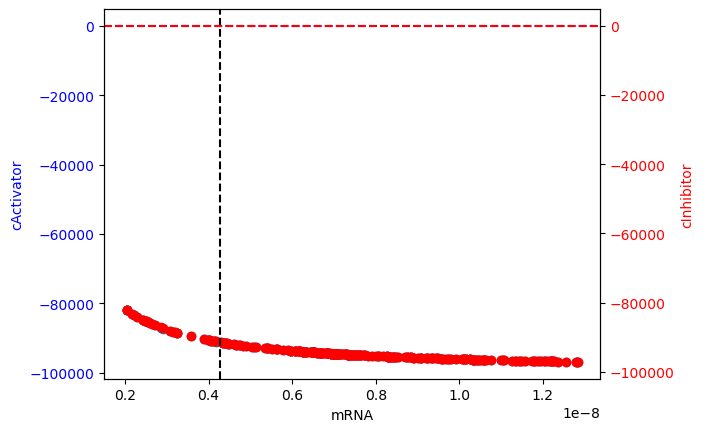

cActivator 0 predicted mRNA = 3.251732634059204e-07
cInhibitor 0 predicted mRNA = 3.251732634059204e-07


In [32]:
# same minimization as above, but let's just try to get cActivator = 0 and cInhibitor = 0 to be the right values

from scipy.optimize import basinhopping
import numpy as np


# modified using Griff's options
grid_use = -1
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])


activator_mRNA_values = list(act_values_df.sort_values(by = 'mRNA').mRNA.values)
inhibitor_mRNA_values = list(inh_values_df.sort_values(by = 'mRNA').mRNA.values)

def objective(x):
    KdRNAPCrp_temp = x[0]
    KdRNAP_temp = x[1]
    kEscape_temp = x[2]
    KeqOpening_temp = x[3]
    
    if KdRNAPCrp_temp > KdRNAP:
        # this doesn't make biological sense
        pass
        #return(1e10) # return a high penalty
    
    mRNA1 = cActivator_to_mRNA(0, KdRNAP = KdRNAP_temp, KdRNAPCrp = KdRNAPCrp_temp, kEscape = kEscape_temp, KeqOpening = KeqOpening_temp)
        
    mRNA2 = cInhibitor_to_mRNA(0, KdRNAP = KdRNAP_temp, KdRNAPCrp = KdRNAPCrp_temp, kEscape = kEscape_temp, KeqOpening = KeqOpening_temp)
    
    diff = 0
    diff += abs(log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()) - mRNA1)
    diff += abs(log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()) - mRNA2)
    return(diff)

# Initial guess for KdRNAP and KdRNAPCrp values
x0 = [KdRNAPCrp, KdRNAP, kEscape, KeqOpening]

# Bounds for KdRNAP and KdRNAPCrp values
n = 1000
bounds = [(KdRNAPCrp/n, KdRNAPCrp*n), (KdRNAP/n, KdRNAP*n), (kEscape/n, kEscape*n), (KeqOpening/n, KeqOpening*n)]

# basinhopping
result = basinhopping(objective,  x0 = x0, minimizer_kwargs={"bounds": bounds}, niter = 100)

if result.success:
    KdRNAP_opt = result.x[0]
    KdRNAPCrp_opt = result.x[1]
    print("Optimization successful.")
    print("KdRNAP =", KdRNAP_opt)
    print("KdRNAPCrp =", KdRNAPCrp_opt)
    print("kEscape =", result.x[2])
    print("KeqOpening =", result.x[3])
else:
    print("Optimization failed. Unable to find suitable values for KdRNAP and KdRNAPCrp.")

# plot
fig, ax = plt.subplots()
vals = mRNA_to_cActivator(act_values_df['mRNA'], KdRNAP = result.x[0], KdRNAPCrp = result.x[1])
ax.scatter(act_values_df['mRNA'], vals)
plt.xlabel('mRNA')
ax.set_ylabel('cActivator', color = 'blue')
ax.tick_params(axis = 'y', labelcolor = 'blue')
ax2 = ax.twinx()
vals = mRNA_to_cInhibitor(act_values_df['mRNA'], KdRNAP = result.x[0], KdRNAPCrp = result.x[1])
ax2.scatter(act_values_df['mRNA'], vals, color = 'red')
ax2.set_ylabel('cInhibitor', color = 'red')
ax2.tick_params(axis = 'y', labelcolor = 'red')
plt.axvline(x = 10**(-8.368632), linestyle = '--', color = 'k')
ax2.axhline(y = 0, linestyle = '--', color = 'red')
ax.axhline(y = 0, linestyle = '--', color = 'blue')
plt.show()

print('cActivator 0 predicted mRNA = '+str(cActivator_to_mRNA(0, KdRNAP = result.x[0], KdRNAPCrp = result.x[1], kEscape = result.x[2], KeqOpening = result.x[3])))
print('cInhibitor 0 predicted mRNA = '+str(cInhibitor_to_mRNA(0, KdRNAP = result.x[0], KdRNAPCrp = result.x[1], kEscape = result.x[2], KeqOpening = result.x[3])))

1e-05


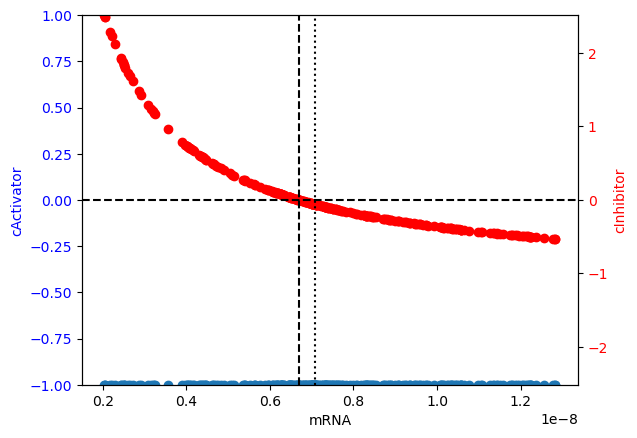

1.0000000000000002e-06


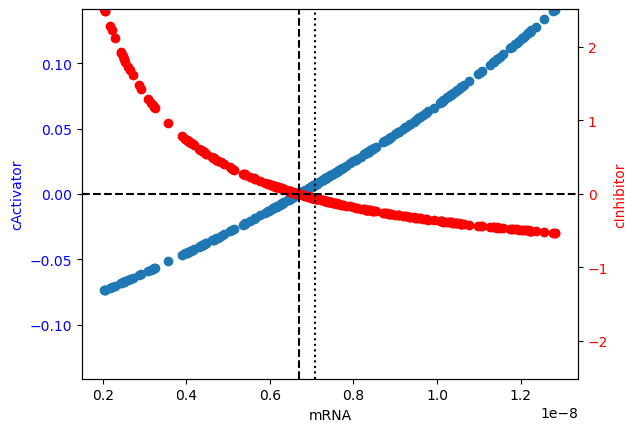

1.0000000000000001e-07


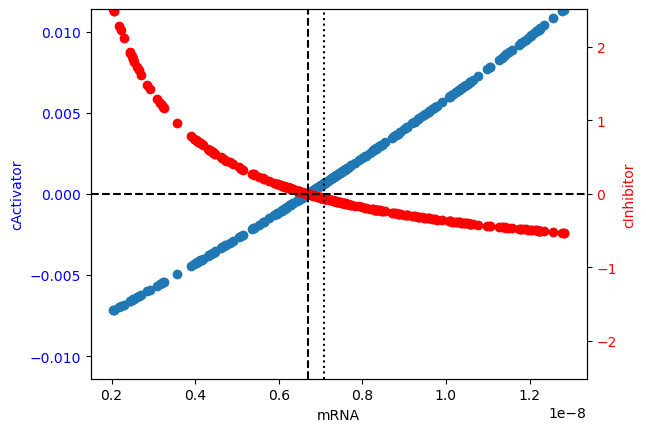

1e-08


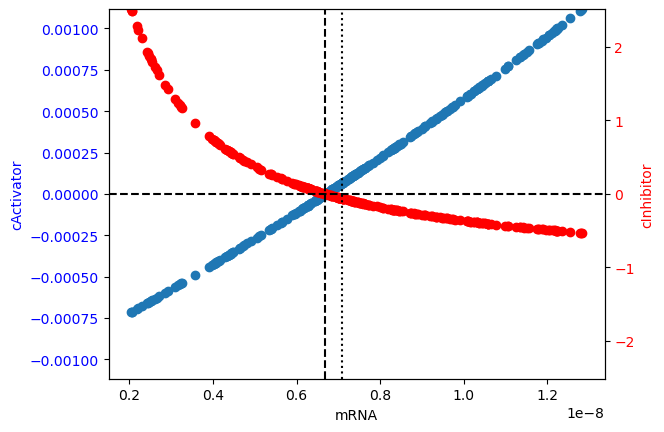

1e-09


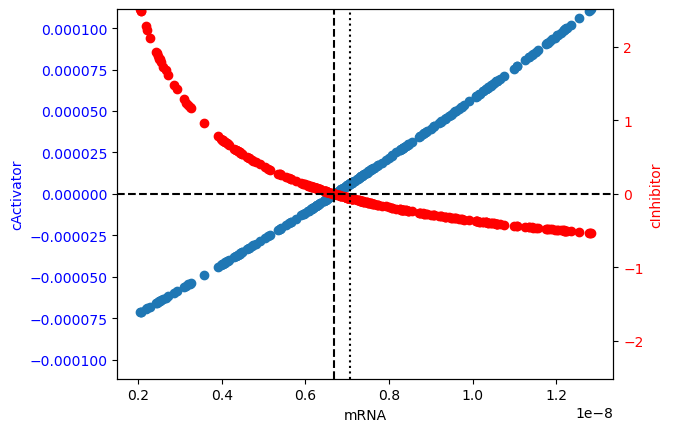

1.0000000000000002e-10


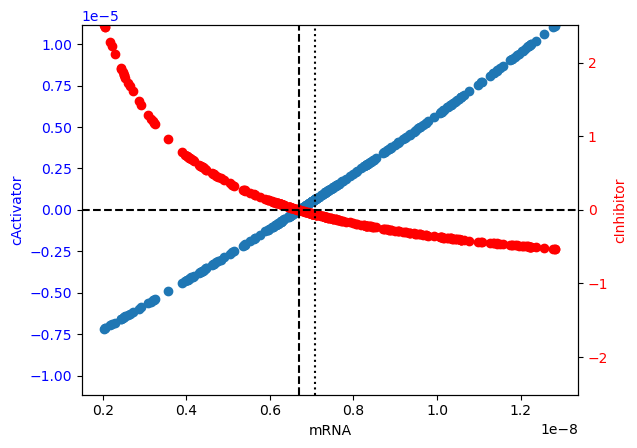

1.0000000000000001e-11


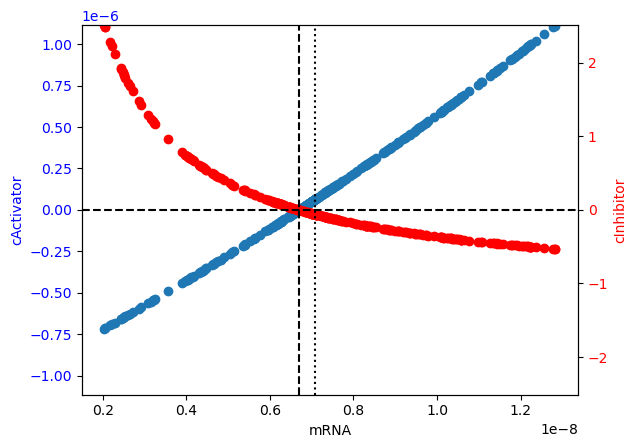

1e-12


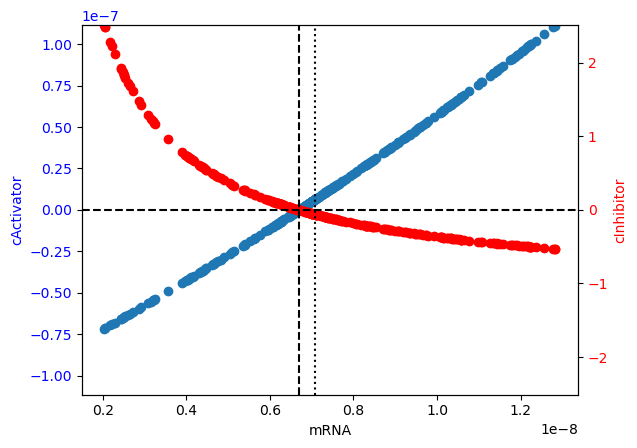

1.0000000000000002e-13


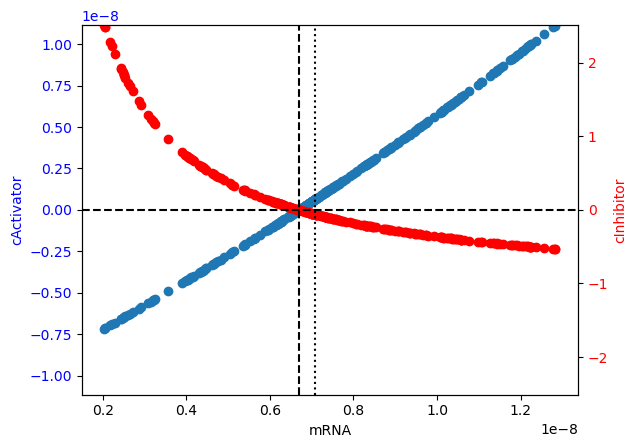

1.0000000000000002e-14


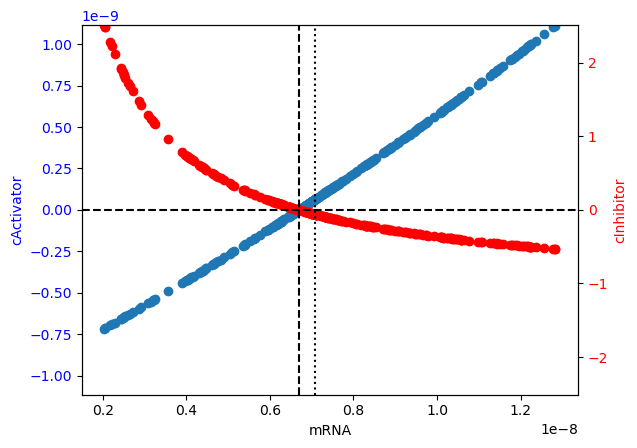

1e-15


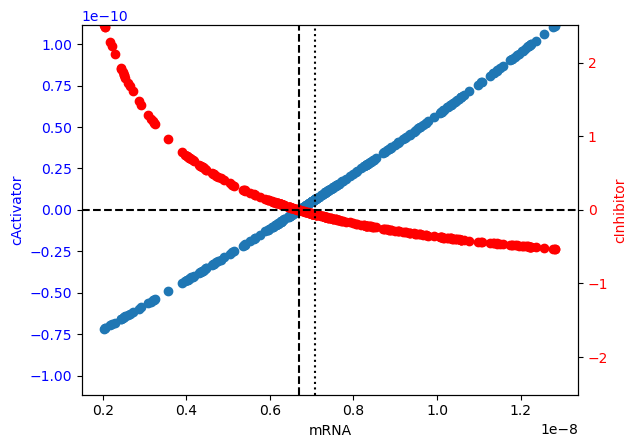

1e-16


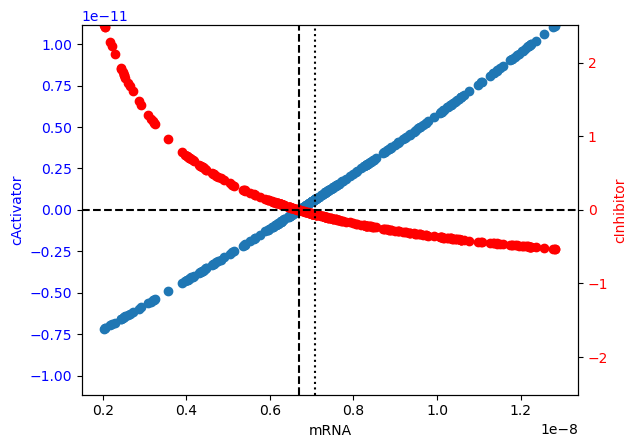

1e-17


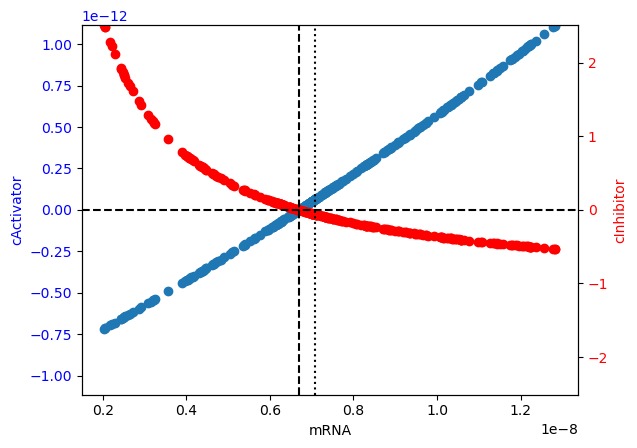

1e-18


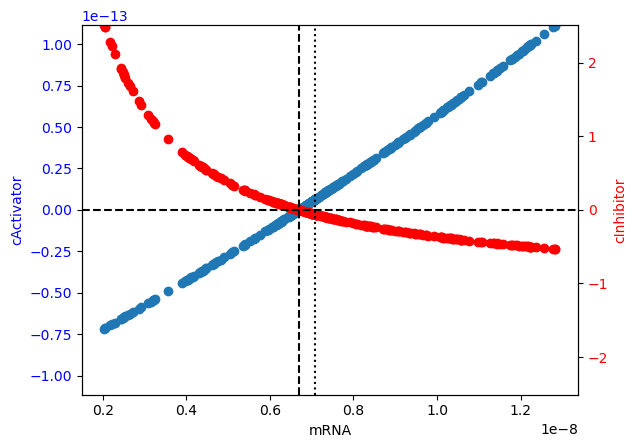

1.0000000000000001e-19


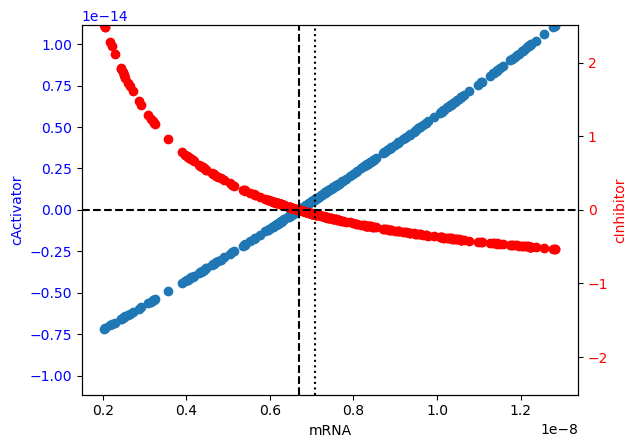

1.0000000000000001e-20


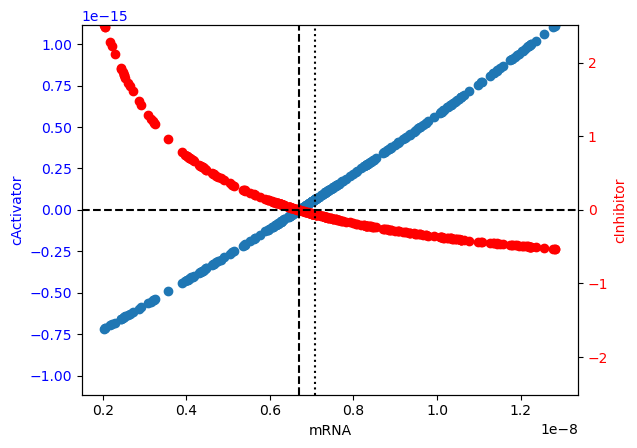

1.0000000000000001e-21


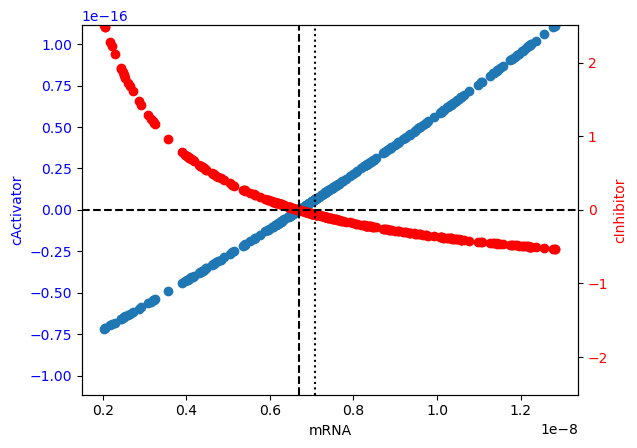

1.0000000000000002e-22


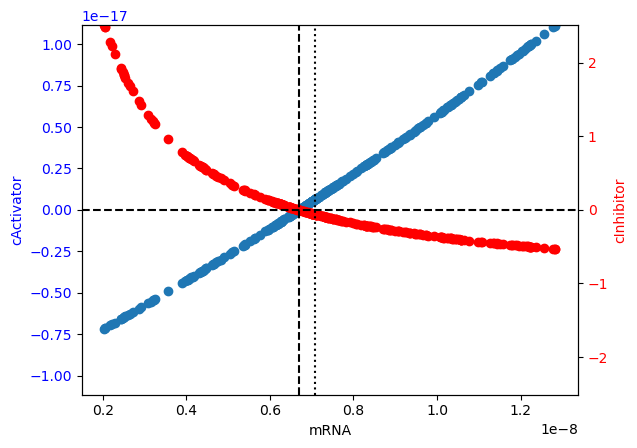

1.0000000000000001e-23


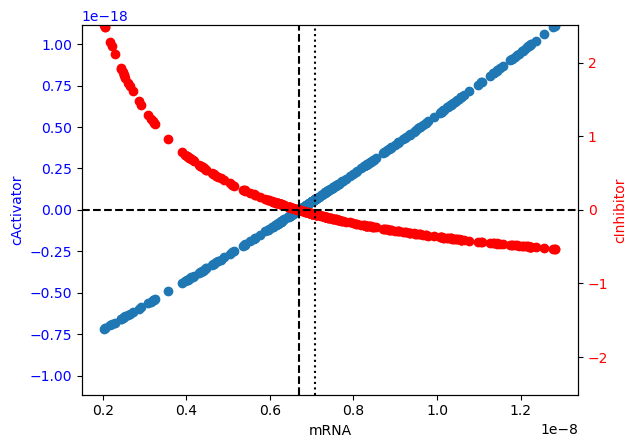

1.0000000000000001e-24


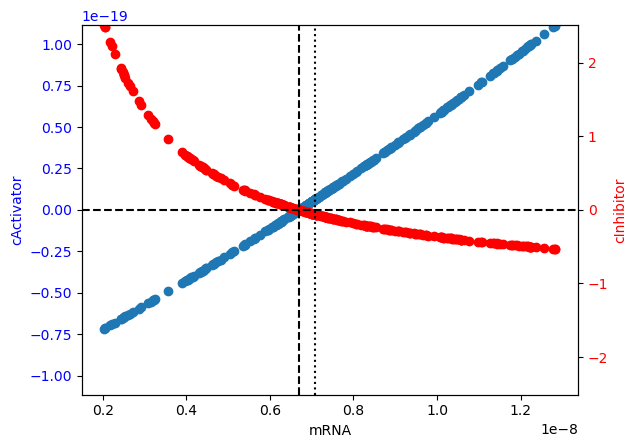

In [7]:
# Dan's suggestion - set cInhibitor to 0 to study cActivator and sweep values of KdRNAPCrp
# cInhibitor is not dependent on KdRNAPCrp so this doesn't really matter to it

# chatGPT suggestion - use scipy to solve, only modify KdRNAPCrp
from scipy.optimize import basinhopping
import numpy as np

# modified using Griff's options
grid_use = -1
KdRNAP = 10**(grid_vals[grid_use][0])
kEscape = 10**(grid_vals[grid_use][1])
KeqOpening = 10**(grid_vals[grid_use][2])


# plot
for val in range(20):
    KdRNAPCrp_temp = KdRNAP*10**(-val)
    print(KdRNAPCrp_temp)
    fig, ax = plt.subplots()
    vals = mRNA_to_cActivator(act_values_df['mRNA'], KdRNAPCrp = KdRNAPCrp_temp)
    ax.scatter(act_values_df['mRNA'], vals)
    plt.xlabel('mRNA')
    ax.set_ylabel('cActivator', color = 'blue')
    ax.tick_params(axis = 'y', labelcolor = 'blue')
    ax.set_ylim(-max(abs(vals)), max(abs(vals)))
    ax2 = ax.twinx()
    vals = mRNA_to_cInhibitor(act_values_df['mRNA'], KdRNAPCrp = KdRNAPCrp_temp)
    ax2.scatter(act_values_df['mRNA'], vals, color = 'red')
    ax2.set_ylabel('cInhibitor', color = 'red')
    ax2.tick_params(axis = 'y', labelcolor = 'red')
    ax2.set_ylim(-max(abs(vals)), max(abs(vals)))
    plt.axvline(x = log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()), linestyle = '--', color = 'k')
    plt.axvline(x = act_values_df.loc[controls]['mRNA'].mean(), linestyle = 'dotted', color = 'k')
    ax2.axhline(y = 0, linestyle = '--', color = 'k')
    plt.show()

# predicting

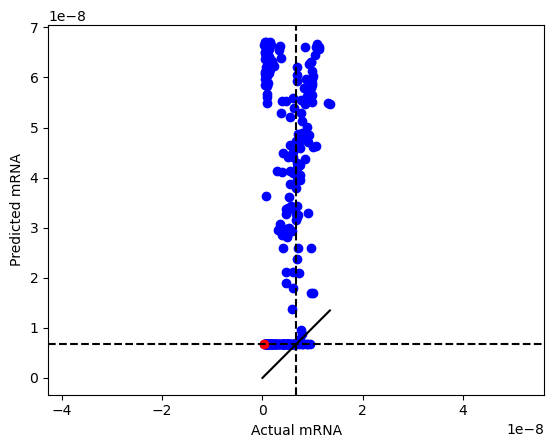

In [19]:
# let's convert A matrix values to cActivator and cInhibitor values
# start with just plotting them against each other
Kd_RNAP_crp = 1.0000000000000002e-06
predicted_mRNA = []
actual_mRNA = list(act_values_df.actual_mRNA)
for index in act_values_df.index:
    cActivator 
cActivator_cInhibitor_to_mRNA
cActivator_vals = np.array([mRNA_to_cActivator(val, KdRNAPCrp = Kd_RNAP_crp) for val in act_values_df['mRNA'].values]).clip(min = 0)
cInhibitor_vals = np.array(mRNA_to_cInhibitor(inh_values_df['mRNA'], KdRNAPCrp = Kd_RNAP_crp)).clip(min = 0)
predicted_mRNA = cActivator_cInhibitor_to_mRNA(cActivator_vals, cInhibitor_vals)
unhighlighted = []
highlighted = []
for index in act_values_df.index:
    if index in ['p1k_00001', 'p1k_00002', 'ecoli_00001', 'ecoli_00002', 'crp__delar1ar2_glyc__2']:
        highlighted.append(index)
    else:
        unhighlighted.append(index)

# use these cActivator and cInhibitor values to calculate ptsG tpm and compare to known
cActivator_vals = np.array(mRNA_to_cActivator(act_values_df['mRNA'].loc[unhighlighted], KdRNAPCrp = Kd_RNAP_crp)).clip(min = 0)
cInhibitor_vals = np.array(mRNA_to_cInhibitor(inh_values_df['mRNA'].loc[unhighlighted], KdRNAPCrp = Kd_RNAP_crp)).clip(min = 0, max = 0)
predicted_mRNA = cActivator_cInhibitor_to_mRNA(cActivator_vals, cInhibitor_vals)
actual_mRNA = list(act_values_df.loc[unhighlighted].actual_mRNA)
plt.scatter(actual_mRNA, predicted_mRNA, color = 'blue')

cActivator_vals = np.array(mRNA_to_cActivator(act_values_df['mRNA'].loc[highlighted], KdRNAPCrp = Kd_RNAP_crp)).clip(min = 0)
cInhibitor_vals = np.array(mRNA_to_cInhibitor(inh_values_df['mRNA'].loc[highlighted], KdRNAPCrp = Kd_RNAP_crp)).clip(min = 0, max = 0)
predicted_mRNA = cActivator_cInhibitor_to_mRNA(cActivator_vals, cInhibitor_vals)
actual_mRNA = list(act_values_df.loc[highlighted].actual_mRNA)
plt.scatter(actual_mRNA, predicted_mRNA, color = 'red')

plt.xlabel('Actual mRNA')
plt.ylabel('Predicted mRNA')
plt.axvline(x = log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()), color = 'k', linestyle = '--')
plt.axhline(y = log_tpm_to_mRNA_conc(log_tpm_df[controls].loc['b1101'].mean()), color = 'k', linestyle = '--')
plt.axis('equal')
plt.plot([0, max(act_values_df.actual_mRNA)], [0, max(act_values_df.actual_mRNA)], color = 'k')
plt.show()

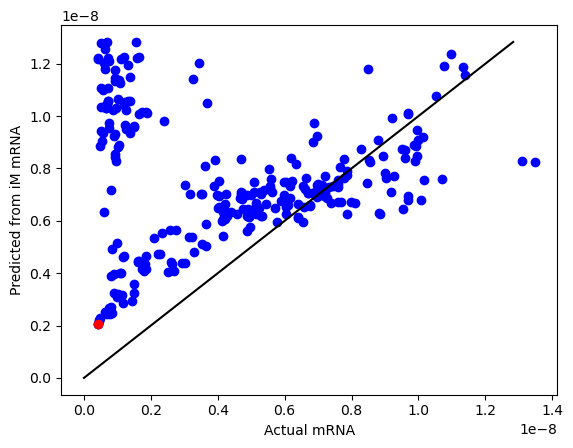

In [17]:
plt.figure()
plt.scatter(act_values_df['actual_mRNA'].loc[unhighlighted], act_values_df['mRNA'].loc[unhighlighted], color = 'blue')
plt.scatter(act_values_df['actual_mRNA'].loc[highlighted], act_values_df['mRNA'].loc[highlighted], color = 'red')
plt.plot([0, max(act_values_df['mRNA'])], [0, max(act_values_df['mRNA'])], color = 'k')
plt.xlabel('Actual mRNA')
plt.ylabel('Predicted from iM mRNA')
plt.show()

In [96]:
mRNA_to_cActivator(4.086637595127048e-10)

7.38977999999911e-07